# Measure Gene interacts Gene Edge Recall

This notebook is designed to estimate how many hetionet edges can be recalled from this weakly supervised approach.
After the discriminator model has been trained, the last step is to predict whether every candidate sentence mentions a gene interacts gene relationship.
Following the predictions, the next step is to group each candidate sentence based on each candidate pair and take the max value of each group.
This max value represents the probability that an edge should or does exist.
Lastly, once each candidate has been scored I use the precision recall curve to estimate how many edges can be recovered from this method.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import math
from pathlib import Path

import numpy as np
import pandas as pd
import plotnine as p9
import plydata as ply
import plydata.tidy as ply_tdy
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sqlalchemy import create_engine

In [2]:
# Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmed_central_db"

# Path subject to change for different os
database_str = (
    f"postgresql+psycopg2://{username}:{password}@/{dbname}?host=/var/run/postgresql"
)
conn = create_engine(database_str)

In [3]:
hetionet_gig_map_df = pd.read_csv(
    Path("../snorkeling_helper/label_functions/knowledge_bases")
    / "gene_interacts_gene.tsv.xz",
    sep="\t",
)
hetionet_gig_map_df >> ply.slice_rows(5)

,gene1_id,gene1_name,gene2_id,gene2_name,sources,n_sentences,hetionet,has_sentence,split,partition_rank
0,1,A1BG,10321,CRISP3,II_literature|hetio-dag,5,1,1,3,0.436432
1,125,ADH1B,10321,CRISP3,NaN,1,0,1,3,0.664368
2,301,ANXA1,10321,CRISP3,NaN,4,0,1,4,0.801239
3,354,KLK3,10321,CRISP3,NaN,4,0,1,3,0.444879
4,367,AR,10321,CRISP3,NaN,8,0,1,4,0.884661


In [4]:
sentence_prediction_df = pd.read_csv(
    "output/all_predicted_gig_sentences.tsv", sep="\t"
) >> ply.arrange("candidate_id")
sentence_prediction_df >> ply.slice_rows(5)

,pred,candidate_id
1056724,0.028647,273
1056725,0.035636,274
1056726,0.036965,275
1056722,0.006021,276
1056723,0.006014,278


In [5]:
sql = """
select candidate_id, gene1_cid as gene1_id, gene2_cid as gene2_id
from gene_gene inner join (
    select sentence_id, document_id
    from sentence
) as sentence_map
on gene_gene.sentence_id = sentence_map.sentence_id
where section = 'title' or section ='abstract'
"""
candidate_to_sentence_map_df = (
    pd.read_sql(sql, conn)
    >> ply_tdy.separate_rows("gene1_id", sep=";")
    >> ply_tdy.separate_rows("gene2_id", sep=";")
    >> ply.call(".astype", {"gene1_id": int, "gene2_id": int})
)
candidate_to_sentence_map_df >> ply.slice_rows(5)

,candidate_id,gene1_id,gene2_id
0,80394,5111,5111
1,162426,6648,6648
2,340241,5829,1072
3,514638,3908,3785
4,702411,1084,1084


# Merge Predictions with Candidates and Hetionet Map

In [6]:
all_gig_predictions_df = (
    sentence_prediction_df
    >> ply.inner_join(candidate_to_sentence_map_df, on="candidate_id")
    >> ply.inner_join(
        hetionet_gig_map_df >> ply.select("-sources", "-n_sentences"),
        on=["gene1_id", "gene2_id"],
    )
)
all_gig_predictions_df >> ply.slice_rows(5)

,pred,candidate_id,gene1_id,gene2_id,gene1_name,gene2_name,hetionet,has_sentence,split,partition_rank
0,0.009936,306,2214,3126,FCGR3A,HLA-DRB4,0,1,3,0.186838
1,0.028243,27576626,2214,3126,FCGR3A,HLA-DRB4,0,1,3,0.186838
2,0.008986,307,2214,925,FCGR3A,CD8A,0,1,3,0.562457
3,0.030561,181646,2214,925,FCGR3A,CD8A,0,1,3,0.562457
4,0.005113,422243,2214,925,FCGR3A,CD8A,0,1,3,0.562457


In [7]:
all_gig_df = (
    all_gig_predictions_df
    >> ply.group_by("gene1_id", "gene2_id")
    >> ply.define(
        pred_max="max(pred)", pred_mean="mean(pred)", pred_median="median(pred)"
    )
    >> ply.select("-pred", "-candidate_id")
    >> ply.distinct()
    >> ply.ungroup()
    >> ply_tdy.gather("metric", "score", ["pred_max", "pred_mean", "pred_median"])
)
all_gig_df >> ply.slice_rows(10)

,gene1_id,gene2_id,gene1_name,gene2_name,hetionet,has_sentence,split,partition_rank,metric,score
0,2214,3126,FCGR3A,HLA-DRB4,0,1,3,0.186838,pred_max,0.028243
1,2214,925,FCGR3A,CD8A,0,1,3,0.562457,pred_max,0.067613
2,3126,925,HLA-DRB4,CD8A,0,1,3,0.009897,pred_max,0.058933
3,26762,26762,HAVCR1,HAVCR1,0,1,3,0.620434,pred_max,0.169719
4,960,79812,CD44,MMRN2,0,1,3,0.592383,pred_max,0.046297
5,960,214,CD44,ALCAM,0,1,3,0.218735,pred_max,0.088906
6,960,3920,CD44,LAMP2,0,1,3,0.464101,pred_max,0.047109
7,79812,214,MMRN2,ALCAM,0,1,3,0.137790,pred_max,0.048018
8,79812,3920,MMRN2,LAMP2,0,1,3,0.463695,pred_max,0.051866
9,214,3920,ALCAM,LAMP2,0,1,3,0.426731,pred_max,0.050189


In [8]:
test_entity_df = all_gig_df >> ply.query("split == 5")
test_entity_df >> ply.slice_rows(5)

,gene1_id,gene2_id,gene1_name,gene2_name,hetionet,has_sentence,split,partition_rank,metric,score
20,5293,6426,PIK3CD,SRSF1,0,1,5,0.965715,pred_max,0.116629
27,5728,5728,PTEN,PTEN,0,1,5,0.997108,pred_max,0.320329
38,22921,253827,MSRB2,MSRB3,0,1,5,0.933276,pred_max,0.090662
70,1636,3827,ACE,KNG1,0,1,5,0.937494,pred_max,0.342082
130,2244,10242,FGB,KCNMB2,0,1,5,0.926956,pred_max,0.080059


# Determine Precision and Recall

In [9]:
performance_map = dict()

In [10]:
precision, recall, pr_threshold = precision_recall_curve(
    test_entity_df >> ply.query("metric=='pred_max'") >> ply.pull("hetionet"),
    test_entity_df >> ply.query("metric=='pred_max'") >> ply.pull("score"),
)

fpr, tpr, roc_threshold = roc_curve(
    test_entity_df >> ply.query("metric=='pred_max'") >> ply.pull("hetionet"),
    test_entity_df >> ply.query("metric=='pred_max'") >> ply.pull("score"),
)

performance_map["PR"] = (
    pd.DataFrame(
        {
            "precision": precision,
            "recall": recall,
            "pr_threshold": np.append(pr_threshold, 1),
        }
    )
    >> ply.define(model=f'"pred_max/AUC={auc(recall, precision):.2f}"')
)

performance_map["AUROC"] = pd.DataFrame(
    {"fpr": fpr, "tpr": tpr, "roc_threshold": roc_threshold}
) >> ply.define(model=f'"pred_max/AUC={auc(fpr, tpr):.2f}"')

In [11]:
precision, recall, pr_threshold = precision_recall_curve(
    test_entity_df >> ply.query("metric=='pred_mean'") >> ply.pull("hetionet"),
    test_entity_df >> ply.query("metric=='pred_mean'") >> ply.pull("score"),
)

fpr, tpr, roc_threshold = roc_curve(
    test_entity_df >> ply.query("metric=='pred_mean'") >> ply.pull("hetionet"),
    test_entity_df >> ply.query("metric=='pred_mean'") >> ply.pull("score"),
)

performance_map["PR"] = performance_map["PR"].append(
    pd.DataFrame(
        {
            "precision": precision,
            "recall": recall,
            "pr_threshold": np.append(pr_threshold, 1),
        }
    )
    >> ply.define(model=f'"pred_mean/AUC={auc(recall, precision):.2f}"')
)

performance_map["AUROC"] = performance_map["AUROC"].append(
    pd.DataFrame({"fpr": fpr, "tpr": tpr, "roc_threshold": roc_threshold})
    >> ply.define(model=f'"pred_mean/AUC={auc(fpr, tpr):.2f}"')
)

In [12]:
precision, recall, pr_threshold = precision_recall_curve(
    test_entity_df >> ply.query("metric=='pred_median'") >> ply.pull("hetionet"),
    test_entity_df >> ply.query("metric=='pred_median'") >> ply.pull("score"),
)

fpr, tpr, roc_threshold = roc_curve(
    test_entity_df >> ply.query("metric=='pred_median'") >> ply.pull("hetionet"),
    test_entity_df >> ply.query("metric=='pred_median'") >> ply.pull("score"),
)

performance_map["PR"] = performance_map["PR"].append(
    pd.DataFrame(
        {
            "precision": precision,
            "recall": recall,
            "pr_threshold": np.append(pr_threshold, 1),
        }
    )
    >> ply.define(model=f'"pred_median/AUC={auc(recall, precision):.2f}"')
)

performance_map["AUROC"] = performance_map["AUROC"].append(
    pd.DataFrame({"fpr": fpr, "tpr": tpr, "roc_threshold": roc_threshold})
    >> ply.define(model=f'"pred_median/AUC={auc(fpr, tpr):.2f}"')
)

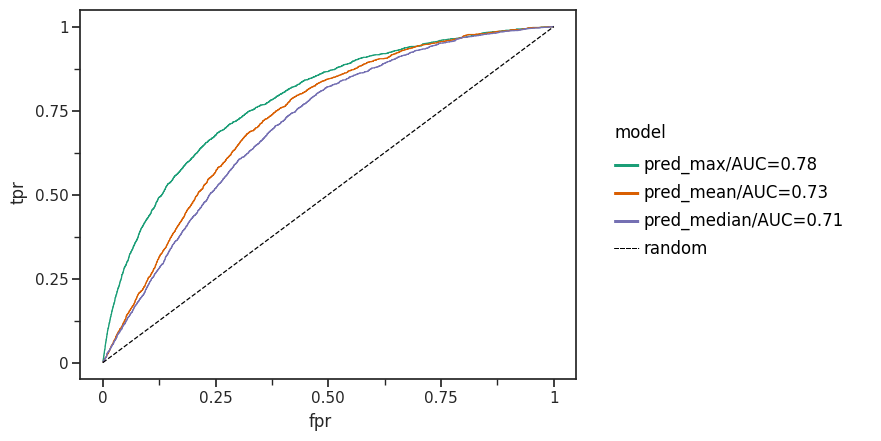

<ggplot: (-9223363291570213425)>


In [13]:
g = (
    p9.ggplot(
        performance_map["AUROC"]
        >> ply.call(
            ".append",
            pd.DataFrame(
                {
                    "fpr": [0, 0.25, 0.5, 0.75, 1],
                    "tpr": [0, 0.25, 0.5, 0.75, 1],
                    "model": "random",
                }
            ),
        )
    )
    + p9.aes(x="fpr", y="tpr", group="model", color="model", linetype="model")
    + p9.geom_line()
    + p9.theme_seaborn("white")
    + p9.scale_color_manual(["#1b9e77", "#d95f02", "#7570b3", "#000000"])
    + p9.scale_linetype_manual(["solid", "solid", "solid", "dashed"])
)
print(g)

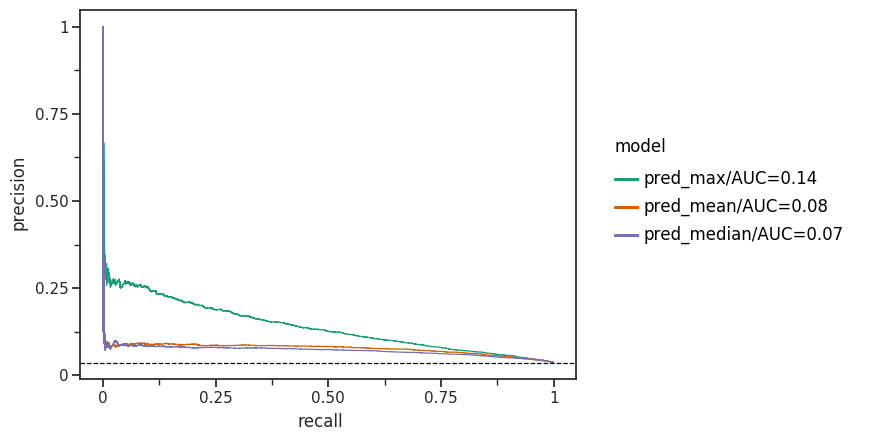

<ggplot: (-9223363291835754485)>


In [14]:
g = (
    p9.ggplot(performance_map["PR"])
    + p9.aes(x="recall", y="precision", group="model", color="model", linetype="model")
    + p9.geom_line()
    + p9.theme_seaborn("white")
    + p9.scale_color_manual(["#1b9e77", "#d95f02", "#7570b3", "#000000"])
    + p9.scale_linetype_manual(["solid", "solid", "solid", "dashed"])
    + p9.geom_hline(
        yintercept=(
            test_entity_df >> ply.query("metric=='pred_median'") >> ply.pull("hetionet")
        ).mean(),
        linetype="dashed",
    )
)
print(g)

## Estimate number of new Edges Added

In [15]:
df_iterator = (
    performance_map["PR"]
    >> ply.query("model.str.contains('max')& pr_threshold < 1")
    >> ply.call(".round", {"pr_threshold": 2})
    >> ply.distinct("pr_threshold", "last")
)

edges_added_records = []
for idx, row in df_iterator.iterrows():
    cutoff = row["pr_threshold"]

    values_added = (
        all_gig_df
        >> ply.query("metric.str.contains('max')")
        >> ply.query("score >= @cutoff")
        >> ply.pull("hetionet")
    )

    edges_added_records.append(
        {
            "edges": values_added.sum(),
            "in_hetionet": "Existing",
            "precision": row["precision"],
            "sen_cutoff": cutoff,
        }
    )

    edges_added_records.append(
        {
            "edges": values_added.shape[0] - values_added.sum(),
            "in_hetionet": "Novel",
            "precision": row["precision"],
            "sen_cutoff": cutoff,
        }
    )


edges_added_df = pd.DataFrame.from_records(edges_added_records)
edges_added_df >> ply.slice_rows(10)

,edges,in_hetionet,precision,sen_cutoff
0,21134,Existing,0.036412,0.00
1,559469,Novel,0.036412,0.00
2,21080,Existing,0.038407,0.01
3,549134,Novel,0.038407,0.01
4,20711,Existing,0.043392,0.02
5,491065,Novel,0.043392,0.02
6,19996,Existing,0.050173,0.03
7,412725,Novel,0.050173,0.03
8,19120,Existing,0.057941,0.04
9,338864,Novel,0.057941,0.04


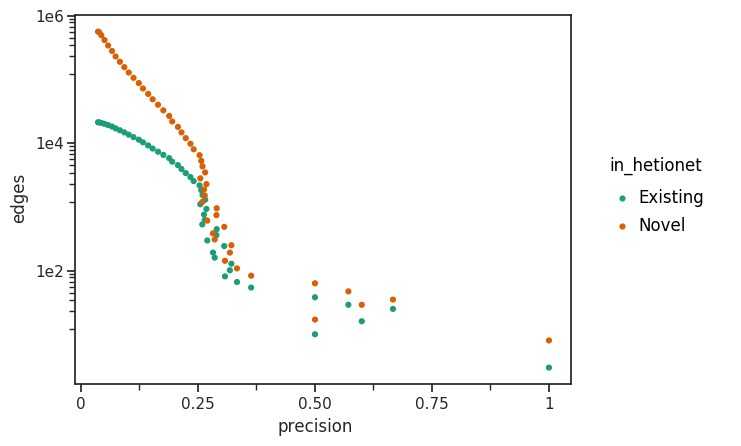

<ggplot: (8745340444613)>


In [16]:
g = (
    p9.ggplot(edges_added_df >> ply.query("edges > 0 & precision > 0"))
    + p9.aes(x="precision", y="edges", color="in_hetionet")
    + p9.geom_point()
    + p9.theme_seaborn("white")
    + p9.scale_color_brewer(type="qual", palette=2)
    + p9.scale_y_log10()
)
print(g)

In [17]:
edges_df = pd.DataFrame.from_records(
    [
        {
            "recall": (
                all_gig_df
                >> ply.query("metric=='pred_max' & score > 0.05")  # precision 0.06627
                >> ply.pull("hetionet")
            ).sum()
            / all_gig_df.query("hetionet == 1").shape[0],
            "edges": (
                all_gig_df
                >> ply.query("metric=='pred_max' & score > 0.05")
                >> ply.pull("hetionet")
            ).sum(),
            "in_hetionet": "Existing",
            "relation": "GiG",
        },
        {
            "edges": (
                all_gig_df
                >> ply.query("metric=='pred_max' & score > 0.05")
                >> ply.query("hetionet==0")
            ).shape[0],
            "in_hetionet": "Novel",
            "relation": "GiG",
        },
    ]
)

edges_df

,recall,edges,in_hetionet,relation
0,0.285969,18131,Existing,GiG
1,NaN,277542,Novel,GiG


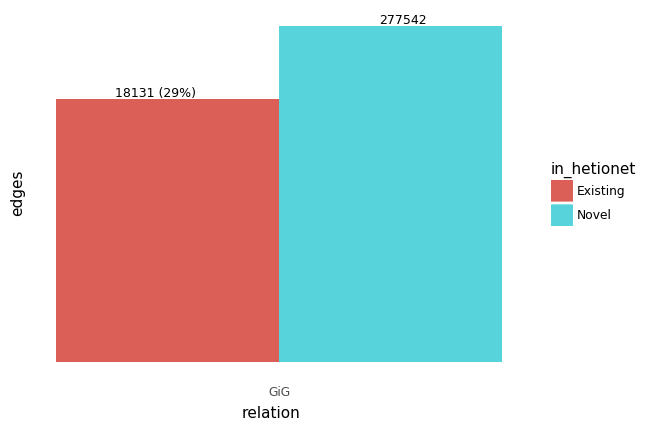

<ggplot: (8745019095104)>


In [18]:
g = (
    p9.ggplot(edges_df, p9.aes(x="relation", y="edges", fill="in_hetionet"))
    + p9.geom_col(position="dodge")
    + p9.geom_text(
        p9.aes(
            label=(
                edges_df.apply(
                    lambda x: f"{x['edges']} ({x['recall']*100:.0f}%)"
                    if not math.isnan(x["recall"])
                    else f"{x['edges']}",
                    axis=1,
                )
            )
        ),
        position=p9.position_dodge(width=1),
        size=9,
        va="bottom",
    )
    + p9.scale_y_log10()
    + p9.theme(
        axis_text_y=p9.element_blank(),
        axis_ticks_major=p9.element_blank(),
        rect=p9.element_blank(),
    )
)
print(g)

# Take home messages

1. Recall is okay. Achieves 29% which is better than originally thought.
2. If the discriminator model trained correctly I hypothesize that the recall would be a lot more higher.